In [2]:
from itertools import count
from collections import defaultdict
from coba.statistics import OnlineMean
from coba.random import CobaRandom
from coba.experiments import Result
from coba.statistics import iqr
from matplotlib import pyplot as plt
from statistics import median, mean, variance
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

In [4]:
full6_4 = Result.from_file("./outcomes/full6_4.log.gz").filter_fin() #corral and CMT with high c/d
full6_5 = Result.from_file("./outcomes/full6_5.log.gz").filter_fin() #CMT with high c and lots of interaction data
full6_6 = Result.from_file("./outcomes/full6_6.log.gz").filter_fin() #CMT with high c and lots of interaction data
#mem_sim = Result.from_file("./outcomes/mem_sim.log.gz").filter_fin()
#print(full6_4)
#print(full6_5)
print(full6_6)
#print(mem_sim)


{'Learners': 2, 'Environments': 6, 'Interactions': 72000}


In [3]:
#df = full6_4.interactions.to_pandas()
#pf = full6_4.interactions.to_progressive_pandas(each=True)

{'Learners': 2, 'Environments': 0, 'Interactions': 0}


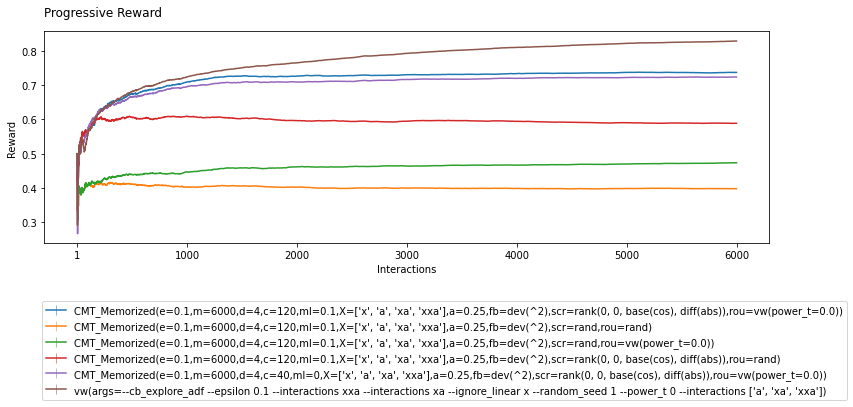

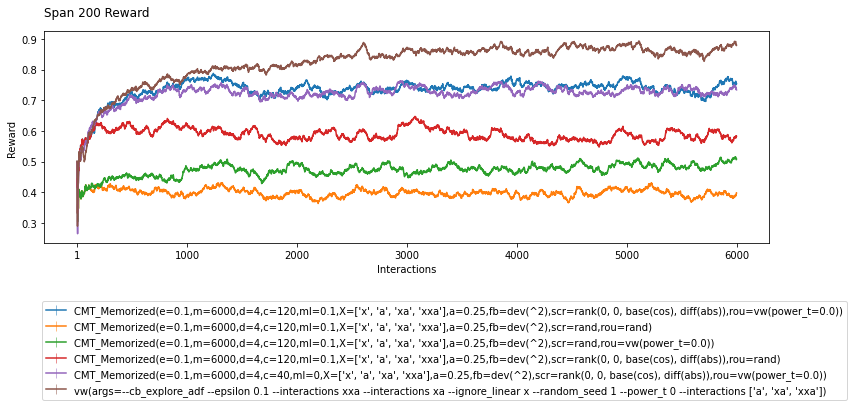

In [5]:
openml = set(full6_4.environments.to_pandas()["openml"]) & set(full6_5.environments.to_pandas()["openml"]) & set(full6_6.environments.to_pandas()["openml"])

f,a = plt.subplots(figsize=(13,6))
full6_4.filter_env(openml=openml).plot_learners(ax=a,xlim=(0,6000))
full6_5.filter_env(openml=openml).plot_learners(ax=a,xlim=(0,6000))
full6_6.filter_env(openml=openml).plot_learners(ax=a,xlim=(0,6000))

f,a = plt.subplots(figsize=(13,6))
full6_4.filter_env(openml=openml).plot_learners(ax=a,xlim=(0,6000),span=200)
full6_5.filter_env(openml=openml).plot_learners(ax=a,xlim=(0,6000),span=200)
full6_6.filter_env(openml=openml).plot_learners(ax=a,xlim=(0,6000),span=200)


plt.show()

# Does tree depth negatively impact performance?

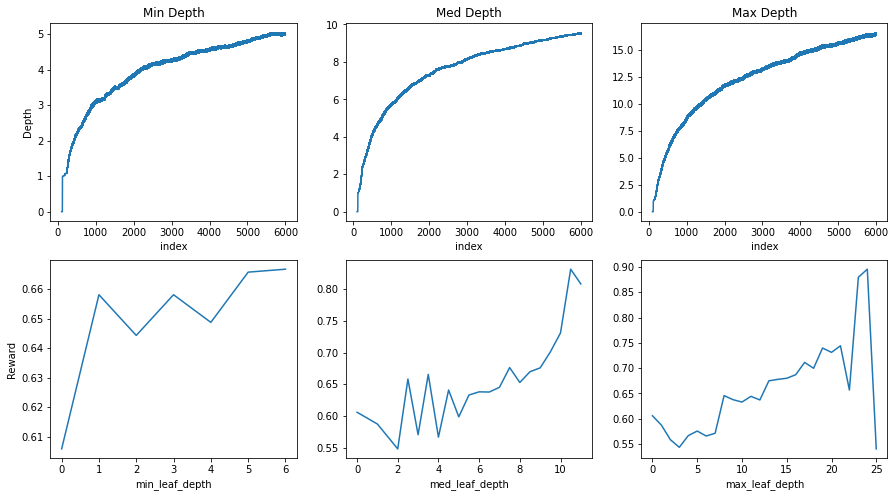

In [6]:
df1 = df.copy()
df1 = df1[df1["index"]>100]

df1["min_leaf_depth"] = df1.apply(lambda r: min([d for d,c in zip(r["leaf_depths"], r["leaf_mem_cnt"]) if c]),axis=1)
df1["med_leaf_depth"] = df1.apply(lambda r: median([d for d,c in zip(r["leaf_depths"], r["leaf_mem_cnt"]) if c]),axis=1)
df1["max_leaf_depth"] = df1.apply(lambda r: max([d for d,c in zip(r["leaf_depths"], r["leaf_mem_cnt"]) if c]),axis=1)

fig, a = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

a[0,0].set_title("Min Depth")
a[0,1].set_title("Med Depth")
a[0,2].set_title("Max Depth")

a[0,0].set_ylabel("Depth")
a[1,0].set_ylabel("Reward")

df1[["min_leaf_depth","index"]].groupby("index").agg(["mean","sem"])["min_leaf_depth"].plot(y="mean",yerr="sem",ax=a[0,0], legend=False)
df1[["min_leaf_depth","reward"]].groupby("min_leaf_depth").agg(["mean","sem"])["reward"].plot(y="mean",ax=a[1,0], legend=False)

df1[["med_leaf_depth","index"]].groupby("index").agg(["mean","sem"])["med_leaf_depth"].plot(y="mean",yerr="sem",ax=a[0,1], legend=False)
df1[["med_leaf_depth","reward"]].groupby("med_leaf_depth").agg(["mean","sem"])["reward"].plot(y="mean",ax=a[1,1], legend=False)

df1[["max_leaf_depth","index"]].groupby("index").agg(["mean","sem"])["max_leaf_depth"].plot(y="mean",yerr="sem",ax=a[0,2], legend=False)
df1[["max_leaf_depth","reward"]].groupby("max_leaf_depth").agg(["mean","sem"])["reward"].plot(y="mean",ax=a[1,2], legend=False)

plt.show()

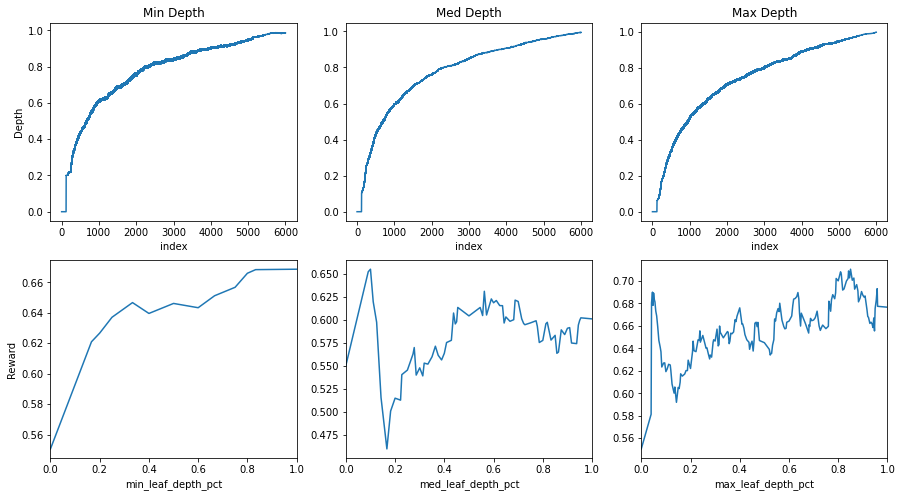

In [47]:
df1 = df.copy()

df1["min_leaf_depth"] = df1.apply(lambda r: min([d for d,c in zip(r["leaf_depths"], r["leaf_mem_cnt"]) if c]),axis=1)
df1["med_leaf_depth"] = df1.apply(lambda r: median([d for d,c in zip(r["leaf_depths"], r["leaf_mem_cnt"]) if c]),axis=1)
df1["max_leaf_depth"] = df1.apply(lambda r: max([d for d,c in zip(r["leaf_depths"], r["leaf_mem_cnt"]) if c]),axis=1)

df1 = pd.merge(df1, df1[["min_leaf_depth","med_leaf_depth","max_leaf_depth","environment_id"]].groupby("environment_id").agg("max"), on=["environment_id"])

df1["min_leaf_depth_pct"] = df1["min_leaf_depth_x"]/df1["min_leaf_depth_y"]
df1["med_leaf_depth_pct"] = df1["med_leaf_depth_x"]/df1["med_leaf_depth_y"]
df1["max_leaf_depth_pct"] = df1["max_leaf_depth_x"]/df1["max_leaf_depth_y"]

fig, a = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

a[0,0].set_title("Min Depth")
a[0,1].set_title("Med Depth")
a[0,2].set_title("Max Depth")

a[0,0].set_ylabel("Depth")
a[1,0].set_ylabel("Reward")

df1[["min_leaf_depth_pct","index"]].groupby("index").agg(["mean","sem"])["min_leaf_depth_pct"].plot(y="mean",yerr="sem",ax=a[0,0], legend=False)
df1[["med_leaf_depth_pct","index"]].groupby("index").agg(["mean","sem"])["med_leaf_depth_pct"].plot(y="mean",yerr="sem",ax=a[0,1], legend=False)
df1[["max_leaf_depth_pct","index"]].groupby("index").agg(["mean","sem"])["max_leaf_depth_pct"].plot(y="mean",yerr="sem",ax=a[0,2], legend=False)

df1[["min_leaf_depth_pct","reward"]].groupby("min_leaf_depth_pct").agg(["mean"])["reward"].rolling(window=10,min_periods=1).mean().plot(y="mean",ax=a[1,0], xlim=(0.,1.), legend=False)
df1[["med_leaf_depth_pct","reward"]].groupby("med_leaf_depth_pct").agg(["mean"])["reward"].rolling(window=20,min_periods=1).mean().plot(y="mean",ax=a[1,1], xlim=(0.,1.), legend=False)
df1[["max_leaf_depth_pct","reward"]].groupby("max_leaf_depth_pct").agg(["mean"])["reward"].rolling(window=20,min_periods=1).mean().plot(y="mean",ax=a[1,2], xlim=(0.,1.), legend=False)

plt.show()


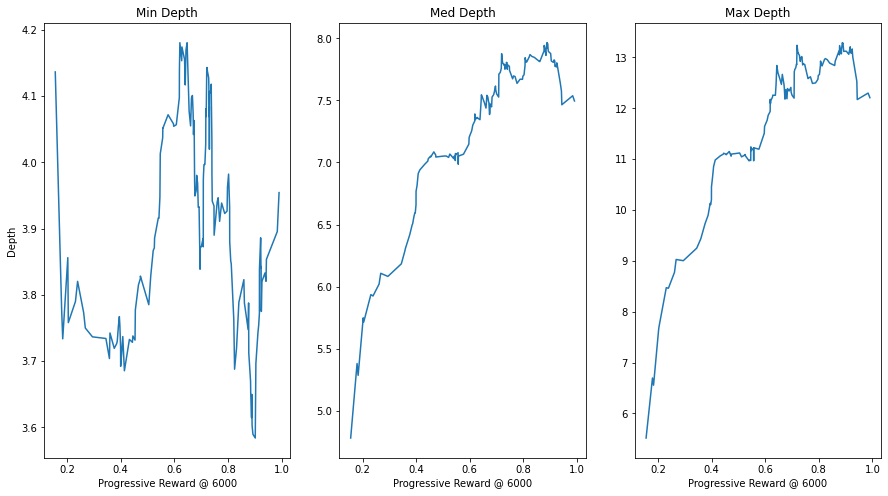

In [19]:

df1 = df.copy()

df1["min_leaf_depth"] = df1.apply(lambda r: min([d for d,c in zip(r["leaf_depths"], r["leaf_mem_cnt"]) if c]),axis=1)
df1["med_leaf_depth"] = df1.apply(lambda r: median([d for d,c in zip(r["leaf_depths"], r["leaf_mem_cnt"]) if c]),axis=1)
df1["max_leaf_depth"] = df1.apply(lambda r: max([d for d,c in zip(r["leaf_depths"], r["leaf_mem_cnt"]) if c]),axis=1)

df1 = pd.merge(df1, pf[["environment_id",6000]])

fig, a = plt.subplots(nrows=1, ncols=3, figsize=(15,8))

a[0].set_title("Min Depth")
a[1].set_title("Med Depth")
a[2].set_title("Max Depth")

a[0].set_ylabel("Depth")

df1[["min_leaf_depth",6000]].groupby(6000).agg(["mean","sem"])["min_leaf_depth"].rolling(window=20,min_periods=1).mean().plot(y="mean",ax=a[0], legend=False)
df1[["med_leaf_depth",6000]].groupby(6000).agg(["mean","sem"])["med_leaf_depth"].rolling(window=20,min_periods=1).mean().plot(y="mean",ax=a[1], legend=False)
df1[["max_leaf_depth",6000]].groupby(6000).agg(["mean","sem"])["max_leaf_depth"].rolling(window=20,min_periods=1).mean().plot(y="mean",ax=a[2], legend=False)

a[0].set_xlabel("Progressive Reward @ 6000")
a[1].set_xlabel("Progressive Reward @ 6000")
a[2].set_xlabel("Progressive Reward @ 6000")

plt.show()

# Does memory composition impact tree performance 

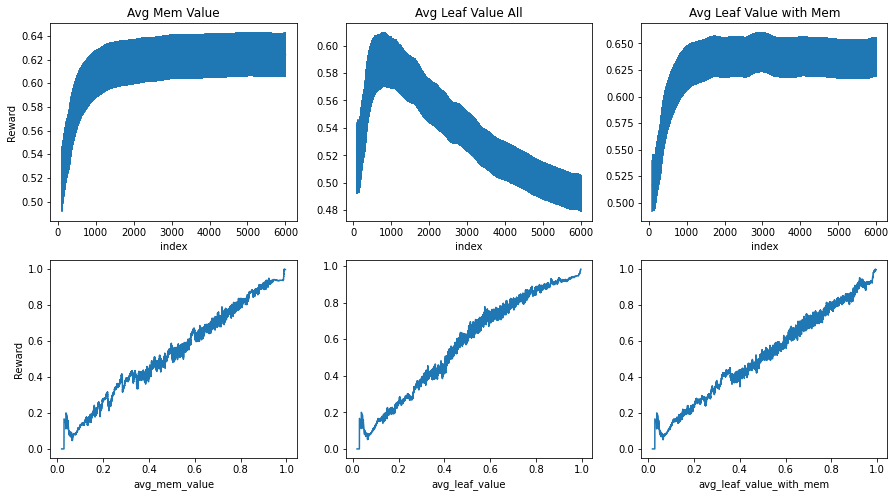

In [8]:
df1 = df.copy()
df1 = df1[df1["index"]>100]

df1["avg_mem_value"]           = df1.apply(lambda r: sum([v*c for v,c in zip(r["leaf_mem_avg"], r["leaf_mem_cnt"])])/sum(r["leaf_mem_cnt"]) ,axis=1)
df1["avg_leaf_value"]          = df1.apply(lambda r: mean(r["leaf_mem_avg"]) ,axis=1)
df1["avg_leaf_value_with_mem"] = df1.apply(lambda r: sum(r["leaf_mem_avg"])/len([c for c in r["leaf_mem_cnt"] if c]) ,axis=1)

fig, a = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

a[0,0].set_title("Avg Mem Value")
a[0,1].set_title("Avg Leaf Value All")
a[0,2].set_title("Avg Leaf Value with Mem")

a[0,0].set_ylabel("Reward")
a[1,0].set_ylabel("Reward")

df1[["avg_mem_value","index"]].groupby("index").agg(["mean","sem"])["avg_mem_value"].rolling(min_periods=1,window=200).mean().plot(y="mean",yerr="sem",ax=a[0,0], legend=False)
df1[["avg_mem_value","reward"]].groupby("avg_mem_value").agg(["mean","sem"])["reward"].rolling(min_periods=1,window=1000).mean().plot(y="mean",ax=a[1,0], legend=False)

df1[["avg_leaf_value","index"]].groupby("index").agg(["mean","sem"])["avg_leaf_value"].rolling(min_periods=1,window=200).mean().plot(y="mean",yerr="sem",ax=a[0,1], legend=False)
df1[["avg_leaf_value","reward"]].groupby("avg_leaf_value").agg(["mean"])["reward"].rolling(min_periods=1,window=1000).mean().plot(y="mean",ax=a[1,1], legend=False)

df1[["avg_leaf_value_with_mem","index"]].groupby("index").agg(["mean","sem"])["avg_leaf_value_with_mem"].rolling(min_periods=1,window=200).mean().plot(y="mean",yerr="sem",ax=a[0,2], legend=False)
df1[["avg_leaf_value_with_mem","reward"]].groupby("avg_leaf_value_with_mem").agg(["mean"])["reward"].rolling(min_periods=1,window=1000).mean().plot(y="mean",ax=a[1,2], legend=False)

plt.show()

# How many leaves have no memory? How often are they selected?

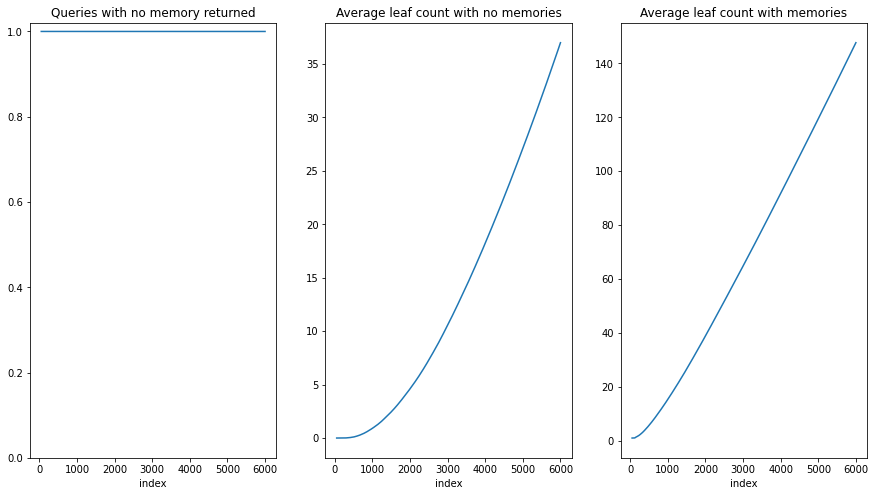

In [30]:
df1 = df.copy()

df1 = df1[(df1["index"]>50)]

df1["is_memory" ]     = df1.apply(lambda r: float(r["action_memories"][r["action_index"]] > -1), axis=1)
df1["zero_leaf_cnt"]  = df1.apply(lambda r: len([c for c in r["leaf_mem_cnt"] if c==0])        , axis=1)
df1["!zero_leaf_cnt"] = df1.apply(lambda r: len([c for c in r["leaf_mem_cnt"] if c!=0])        , axis=1)

f, a = plt.subplots(nrows=1, ncols=3, figsize=(15,8))

a[0].set_title("Queries with memory returned")
a[1].set_title("Average leaf count with no memories")
a[2].set_title("Average leaf count with memories")

df1[["is_memory","index"     ]].groupby("index").agg(["mean"]).expanding().mean().plot(ax=a[0], legend=False, ylim=(0,1.02))
df1[["zero_leaf_cnt","index" ]].groupby("index").agg(["mean"]).expanding().mean().plot(ax=a[1], legend=False)
df1[["!zero_leaf_cnt","index"]].groupby("index").agg(["mean"]).expanding().mean().plot(ax=a[2], legend=False)

plt.show()

# What was the memory value when we were right? Wrong?

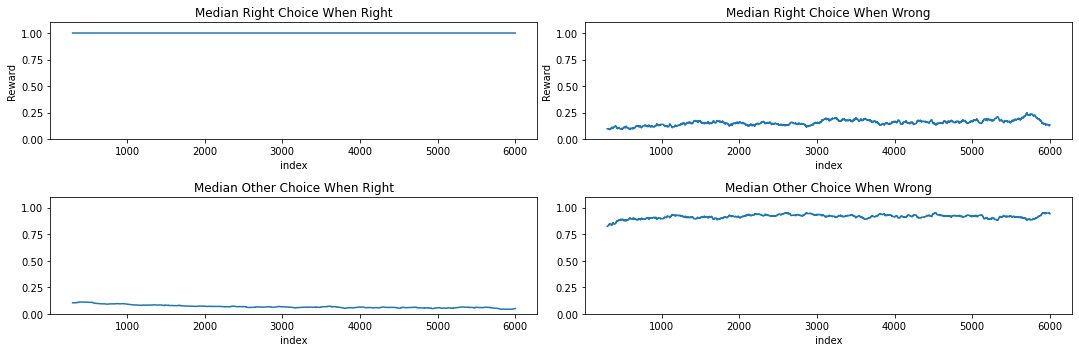

In [21]:
df1 = df.copy()
df0 = df.copy()

df1 = df1[ (df1["index"]>100) & (df1["action_index"]==df1["correct_action"]) ]
df0 = df0[ (df0["index"]>100) & (df0["action_index"]!=df0["correct_action"]) ]

df1["right_memory"] = df1.apply(lambda r: r["action_memories"][r["correct_action"]]                                      ,axis=1)
df1["other_memory"] = df1.apply(lambda r: max([m for i,m in enumerate(r["action_memories"]) if i != r["correct_action"]]),axis=1)

df0["right_memory"] = df0.apply(lambda r: r["action_memories"][r["correct_action"]]                                      ,axis=1)
df0["other_memory"] = df0.apply(lambda r: max([m for i,m in enumerate(r["action_memories"]) if i != r["correct_action"]]),axis=1)

fig, a = plt.subplots(nrows=2, ncols=2, figsize=(15,5))

# right memory vs alternate (when right)
# right memory vs alternate (when wrong)

a[0,0].set_title("Median Right Choice When Right")
a[0,1].set_title("Median Right Choice When Wrong")
a[1,0].set_title("Median Other Choice When Right")
a[1,1].set_title("Median Other Choice When Wrong")

a[0,0].set_ylabel("Reward")
a[0,1].set_ylabel("Reward")

df1[["right_memory","index"]].groupby("index").agg(["median"])["right_memory"].rolling(window=200).mean().plot(y="median", ax=a[0,0], legend=False, ylim=(0.,1.1))
df1[["other_memory","index"]].groupby("index").agg(["median"])["other_memory"].rolling(window=200).mean().plot(y="median", ax=a[1,0], legend=False, ylim=(0.,1.1))

df0[["right_memory","index"]].groupby("index").agg(["median"])["right_memory"].rolling(window=200).mean().plot(y="median", ax=a[0,1], legend=False, ylim=(0.,1.1))
df0[["other_memory","index"]].groupby("index").agg(["median"])["other_memory"].rolling(window=200).mean().plot(y="median", ax=a[1,1], legend=False, ylim=(0.,1.1))

plt.tight_layout()
plt.show()

# How are leaves and values distributed with respect to depth

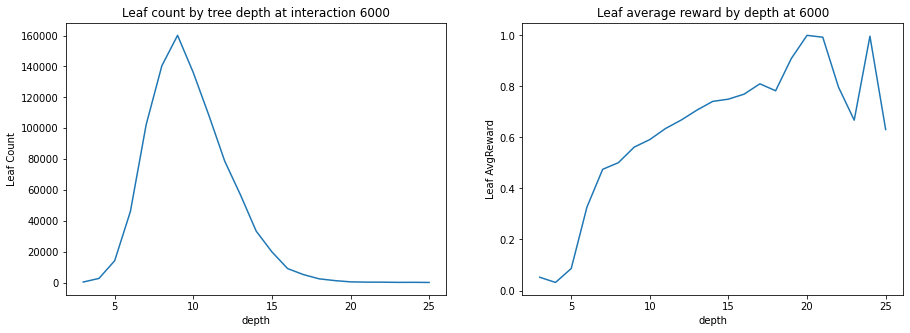

In [48]:
index = 6000

z = 

z = sum(df[df["index"] >= 6000]["leaf_mem_avg"].tolist(),[])
y = sum(df[df["index"] >= 6000]["leaf_mem_cnt"].tolist(),[])
d = sum(df[df["index"] >= 6000]["leaf_depths"].tolist(),[])

fig, a = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

a[0].set_title(f"Memory count by tree depth at interaction {index}")
a[1].set_title(f"Memory average by tree depth at interaction {index}")

a[0].set_ylabel("Leaf Count")
a[1].set_ylabel("Leaf AvgReward")

pd.DataFrame({"count":y, "depth":d}).groupby("depth").agg("sum").plot(ax=a[0], legend=False)
pd.DataFrame({"value":z, "depth":d}).groupby("depth").agg("median").plot(ax=a[1], legend=False)
plt.show()


# Summary:

* We know when we are wrong the right action is given an incredibly low value over 50% of the time 
* We know that tree-depth alone doesn't explain the tree learning plateau
* We know that high valued memories tend to get pushed deeper into the tree (over 50% of leaves below depth 15 have average reward > .8)

# Smoking gun?

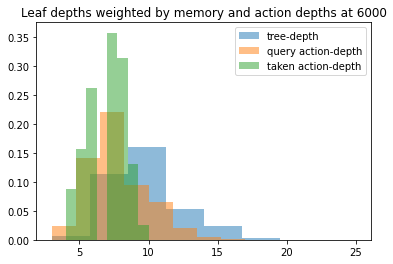

In [49]:
index = 6000

z = sum(df[df["index"] >= 6000]["leaf_mem_avg"].tolist(),[])
y = sum(df[df["index"] >= 6000]["leaf_mem_cnt"].tolist(),[])
d = sum(df[df["index"] >= 6000]["leaf_depths"].tolist(),[])
w = sum(df[df["index"] >= 6000]["leaf_mem_cnt"].tolist(),[])
a = sum(df[df["index"] >= 6000]["action_leaf_depths"].tolist(),[])
A = df[df["index"] >= 6000].apply(lambda r: r["leaf_depths"][r["action_index"]],axis=1)

z = [zz for zz,yy in zip(z,y) if yy > 0]
d = [dd for dd,yy in zip(d,y) if yy > 0]
w = [ww for ww,yy in zip(w,y) if yy > 0]
y = [yy for yy    in       y  if yy > 0]

plt.title(f"Leaf depths weighted by memory and action depths at {index}")
plt.hist(d, weights=w, density=True, label="tree-depth"        , alpha=0.5, bins=8)
plt.hist(a,            density=True, label="query action-depth", alpha=0.5, bins=8)
plt.hist(A,            density=True, label="taken action-depth", alpha=0.5, bins=8)
plt.legend()
plt.show()

# How do memories get deep?

array([[<AxesSubplot:title={'center':'update_mem_leaf_depth'}>]],
      dtype=object)

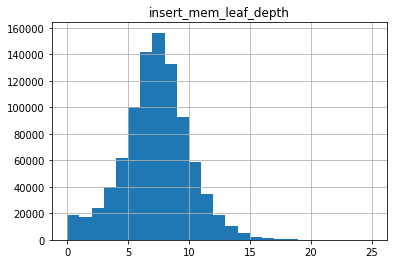

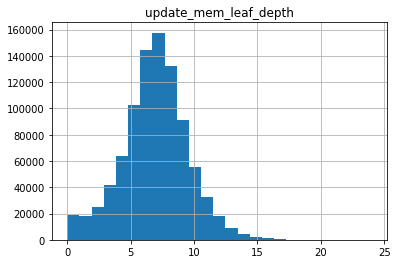

In [52]:
df[["insert_mem_leaf_depth"]].hist(bins=25,density=False)
df[["update_mem_leaf_depth"]].hist(bins=25,density=False)

# What do leaves look like in a full tree?

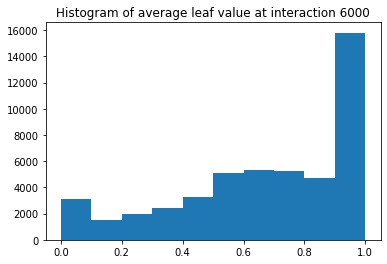

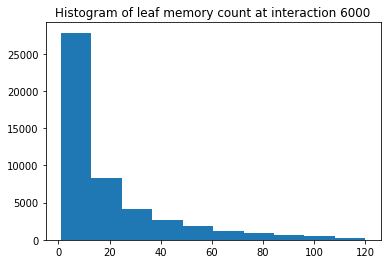

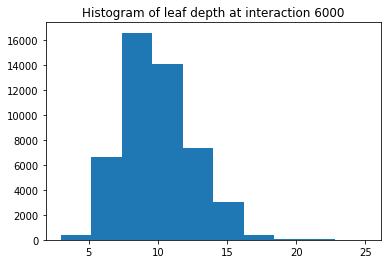

In [72]:

index = 6000

z = sum(df[df["index"] >= 6000]["leaf_mem_avg"].tolist(),[])
y = sum(df[df["index"] >= 6000]["leaf_mem_cnt"].tolist(),[])
d = sum(df[df["index"] >= 6000]["leaf_depths"].tolist(),[])

z = [zz for zz,yy in zip(z,y) if yy > 0]
d = [dd for dd,yy in zip(d,y) if yy > 0]
y = [yy for yy    in       y  if yy > 0]

plt.title(f"Histogram of average leaf value at interaction {index}")
plt.hist(z)
plt.show()

plt.title(f"Histogram of leaf memory count at interaction {index}")
plt.hist(y)
plt.show()

plt.title(f"Histogram of leaf depth at interaction {index}")
plt.hist(d)
plt.show()

# What do the various tree actions look like with respect to depth

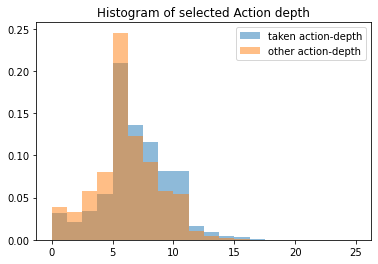

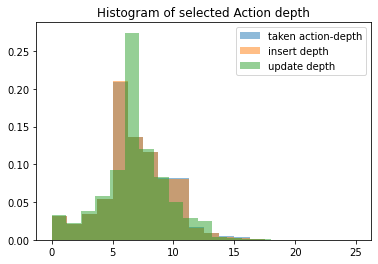

In [91]:
df1 = df.copy()

df1["taken_action_depth"] = df1.apply(lambda r: r["action_leaf_depths"][r["action_index"]],axis=1)
df1["other_action_depth"] = df1.apply(lambda r: r["action_leaf_depths"][sorted([(m,i) for i,m in enumerate(r["action_memories"]) if i != r["action_index"]])[-1][1]] ,axis=1)

plt.title(f"Histogram of selected Action depth")
plt.hist(df1["taken_action_depth"], density=True, label="taken action-depth", alpha=0.5, bins=20)
plt.hist(df1["other_action_depth"], density=True, label="other action-depth", alpha=0.5, bins=20)
plt.legend()
plt.show()

#this is really interesting... The action I take determines where I insert...
plt.title(f"Histogram of selected Action depth")
plt.hist(df1["taken_action_depth"], density=True, label="taken action-depth", alpha=0.5, bins=20)
plt.hist(df1["insert_mem_leaf_depth"], density=True, label="insert depth", alpha=0.5, bins=20)
plt.hist(df1["update_mem_leaf_depth"], density=True, label="update depth", alpha=0.5, bins=20)
plt.legend()
plt.show()

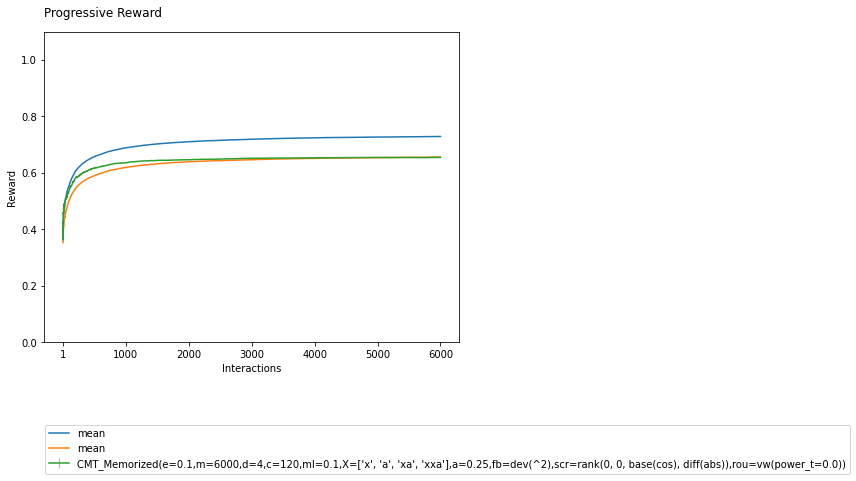

In [73]:
df1 = df.copy()

rng = CobaRandom(1)

df1["right_memory_explore"] = df1.apply(lambda r: r["action_memories"][r["correct_action"]] if rng.random() <= .9 else 0         ,axis=1)
df1["right_memory"]         = df1.apply(lambda r: r["action_memories"][r["correct_action"]]                                      ,axis=1)
df1["other_memory"]         = df1.apply(lambda r: max([m for i,m in enumerate(r["action_memories"]) if i != r["correct_action"]]),axis=1)

fig, a = plt.subplots(ncols=1, figsize=(10,5))

# right memory vs alternate (when right)
# right memory vs alternate (when wrong)

#a[0].set_title("Progressive Right Choice Memory")
a.set_ylabel("Reward")

df1[["right_memory","index"]].groupby("index").agg(["mean"])["right_memory"].expanding().mean().plot(y="mean", ax=a, legend=False, ylim=(0.,1.1))
df1[["right_memory_explore","index"]].groupby("index").agg(["mean"])["right_memory_explore"].expanding().mean().plot(y="mean", ax=a, legend=False, ylim=(0.,1.1))
full6_4.plot_learners(ax=a,xlim=(0,6000),span=None)

plt.tight_layout()
plt.show()

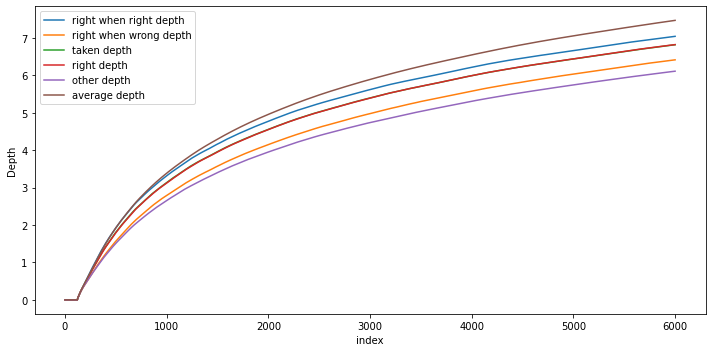

In [92]:
if 1:
    df1 = df.copy()
    
    df1["taken_depth"]         = df1.apply(lambda r: r["action_leaf_depths"][r["action_index"]]                                                                            , axis=1)
    df1["right_depth"]         = df1.apply(lambda r: r["action_leaf_depths"][r["correct_action"]]                                                                          , axis=1)
    df1["other_depth"]         = df1.apply(lambda r: r["action_leaf_depths"][sorted([(m,i) for i,m in enumerate(r["action_memories"]) if i != r["correct_action"]])[-1][1]], axis=1)
    df1["average_depth"]       = df1.apply(lambda r: sum([d*c/r["index"] for d,c in zip(r["leaf_depths"],r["leaf_mem_cnt"])])                                              , axis=1)
                                                           
fig, a = plt.subplots(ncols=1, figsize=(10,5))

a.set_ylabel("Depth")

df1[df1["action_index"]==df1["correct_action"]][["right_depth","index"]].groupby("index").agg(["mean"])["right_depth"].expanding().mean().plot(y="mean", ax=a, label='right when right depth', legend=False)
df1[df1["action_index"]!=df1["correct_action"]][["right_depth","index"]].groupby("index").agg(["mean"])["right_depth"].expanding().mean().plot(y="mean", ax=a, label='right when wrong depth', legend=False)
df1[["taken_depth","index"]].groupby("index").agg(["mean"])["taken_depth"].expanding().mean().plot(y="mean", ax=a, label='taken depth', legend=False)
df1[["right_depth","index"]].groupby("index").agg(["mean"])["right_depth"].expanding().mean().plot(y="mean", ax=a, label='right depth', legend=False)
df1[["other_depth","index"]].groupby("index").agg(["mean"])["other_depth"].expanding().mean().plot(y="mean", ax=a, label='other depth', legend=False)
df1[["average_depth","index"]].groupby("index").agg(["mean"])["average_depth"].expanding().mean().plot(y="mean", ax=a, label='average depth', legend=False)

plt.legend()
plt.tight_layout()
plt.show()

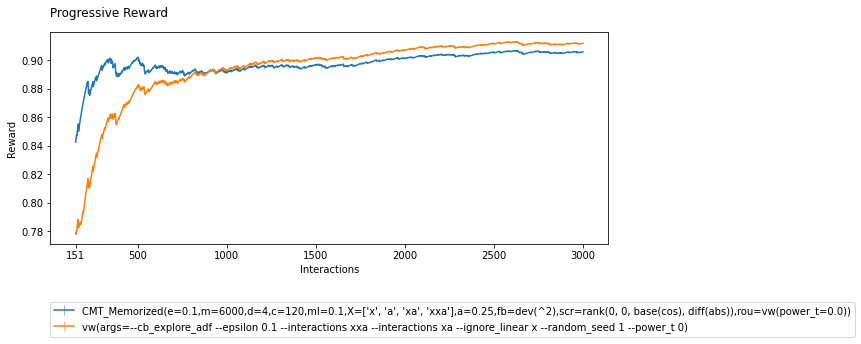

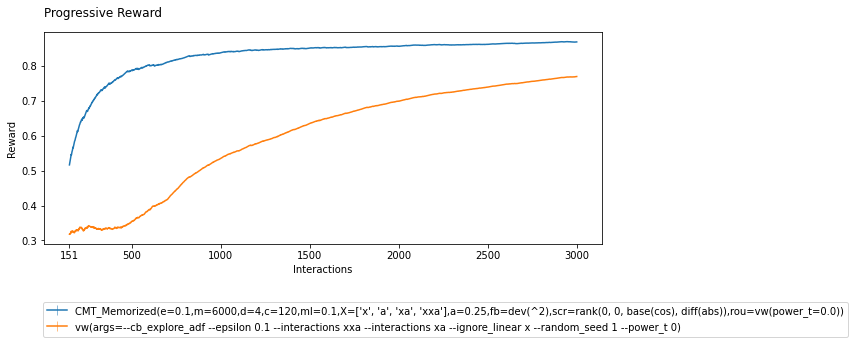

In [30]:
mem_sim.filter_env(n_feat=2,n_act=5,n_anch=2).plot_learners()
mem_sim.filter_env(n_feat=2,n_act=30,n_anch=2).plot_learners()

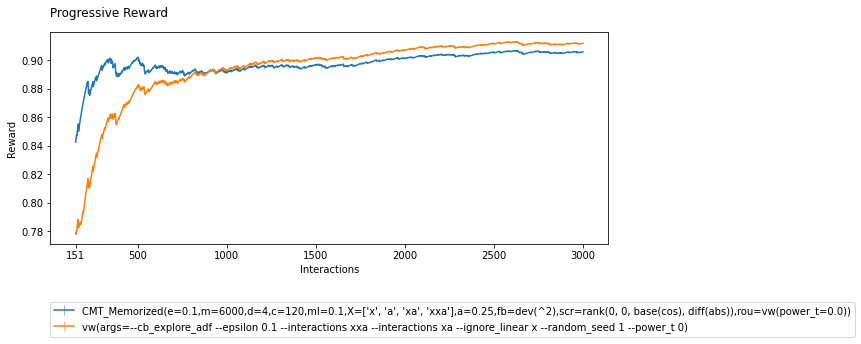

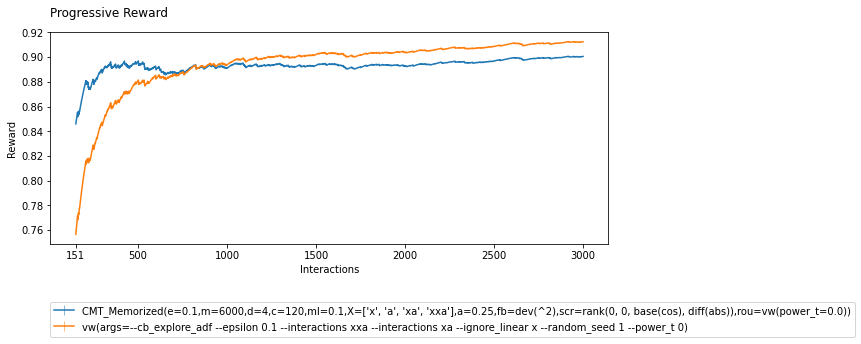

In [33]:
mem_sim.filter_env(n_feat=2,n_act=5,n_anch=2).plot_learners()
mem_sim.filter_env(n_feat=40,n_act=5,n_anch=2).plot_learners()

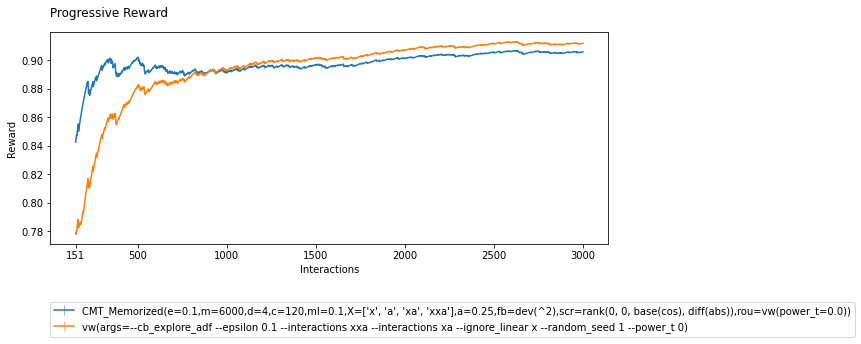

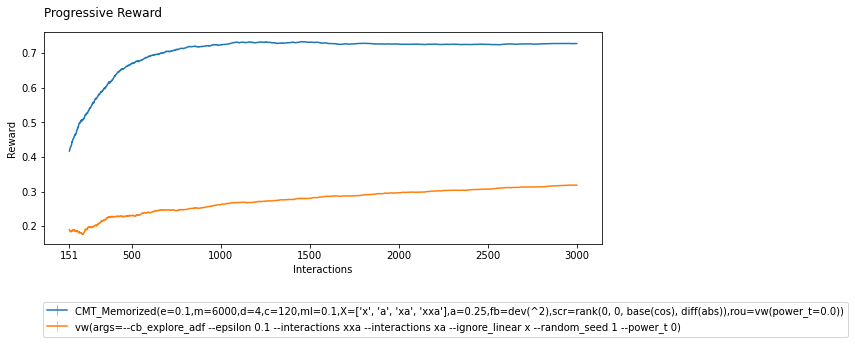

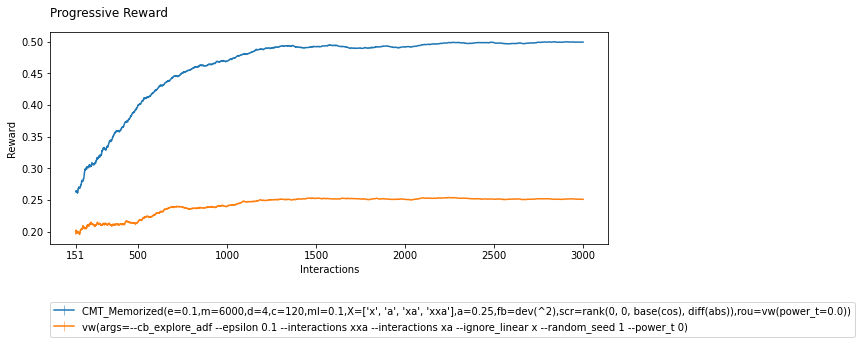

In [35]:
mem_sim.filter_env(n_feat=2,n_act=5,n_anch=2).plot_learners()
mem_sim.filter_env(n_feat=2,n_act=5,n_anch=30).plot_learners()
mem_sim.filter_env(n_feat=2,n_act=5,n_anch=100).plot_learners()